In [184]:
import numpy as np
import pandas as pd
import astroquery
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from numpy.random import poisson, beta, uniform
import matplotlib

import occSimFuncs as occFunc
from tvguide import TessPointing

from astropy.coordinates import SkyCoord
from astropy import units as u

%matplotlib inline

In [5]:
msun = 1.9891E30
rsun = 695500000.
G = 6.67384E-11
AU = 149597870700.

consts = {'sigma_threshold': 7.3}

def get_insol(teff, ars):
    p1 = (teff/5771)**4
    p2 = (215.1 / ars)**2
    return p1 * p2

In [6]:
fn = '../data/cvz-south-plus-planets.csv.bz2'

newDF = pd.read_csv(fn)

In [7]:
newDF['nsectors'] = np.round(newDF.obs_len/27.4)


nt1 = np.floor((4*27.4) / newDF.planetPeriod)
newDF['Ntransits_4months'] = np.where(newDF['T0'] < (4*27.4) % newDF.planetPeriod, nt1+1,nt1)
newDF['needed_for_detection_4months'] = (newDF.transit_depth_diluted * newDF.duration_correction *
                    np.sqrt(np.round(newDF.Ntransits_4months))) / consts['sigma_threshold']


In [8]:
newDF['detected'] = ((newDF.noise_level < newDF.needed_for_detection) &
                     (newDF.Ntransits >= 3) & (newDF.planetRadius > 0.0) & newDF.has_transits)
newDF['detected_4months'] = ((newDF.noise_level < newDF.needed_for_detection_4months) &
                             (newDF.Ntransits_4months >= 3) & (newDF.planetRadius > 0.0) & newDF.has_transits)

total_planets = newDF.detected.sum()
total_planets_4months = newDF.detected_4months.sum()
print('total planets = {}'.format(total_planets))
print('total planets in 4 months= {}'.format(total_planets_4months))
detected_DF = newDF[newDF.detected == True]

detected4_DF = newDF[newDF.detected_4months == True]

total planets = 568
total planets in 4 months= 353


In [9]:
print(newDF.sort_values('PRIORITY').iloc[:-6000].loc[newDF.detected == True].shape[0])

492


In [11]:
print(newDF.sort_values('PRIORITY').iloc[:-6000].loc[newDF.detected_4months == True].shape[0])

305


In [12]:
q = newDF.sort_values('PRIORITY').iloc[:-6000].loc[newDF.detected_4months == True]
q1 = newDF.sort_values('PRIORITY').iloc[-6000:].loc[newDF.detected_4months == True]

(array([  0.,   2.,   2.,   8.,   8.,   1.,  17.,   4.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5]),
 <a list of 19 Patch objects>)

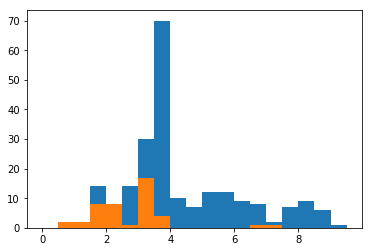

In [13]:
plt.hist(q.planetRadius, bins=np.arange(0,10,0.5))
plt.hist(q1.planetRadius, bins=np.arange(0,10,0.5))

In [412]:
qhigh = q[q.ECLAT <=-75]
q1high = q1[q1.ECLAT <=-75]

print(qhigh.shape[0], q1high.shape[0], q1high.shape[0] + qhigh.shape[0])
print(q.shape[0], q1.shape[0], q1.shape[0] + q.shape[0])

226 48 274
305 48 353


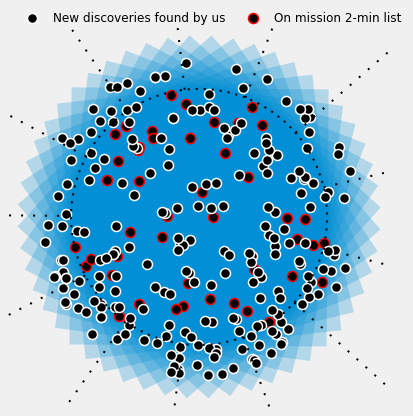

In [347]:

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Wedge, Rectangle
with plt.style.context('fivethirtyeight'):
    fig, ax1 = plt.subplots(1,1, figsize=[6,6])
    m = Basemap(projection='aeqd',lon_0=0,lat_0=-90,resolution='l', ax=ax1, celestial=True,
               width=40E5, height=40E5)
#     m.scatter(newDF.ECLONG.values, newDF.ECLAT.values, 
#               s=0.1, alpha=0.1, latlon=True, marker='^',
#              color='m')

    m.scatter(qhigh.ECLONG.values, qhigh.ECLAT.values, 
              s=100.0, alpha=1.0, latlon=True, marker='o',
             color='k', edgecolor='white', linewidths=1.5, zorder=20, label='New discoveries found by us')
    m.scatter(q1high.ECLONG.values, q1high.ECLAT.values, 
              s=100.0, alpha=1.0, latlon=True, marker='o',
             color='k', edgecolor='red', linewidths=1.5, zorder=19, label='On mission 2-min list')
    
    parallels = [-78., -54, -30, -6, 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, dashes=[1,3], linewidth=2, zorder=21)
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians, dashes=[1,5], latmax=78, linewidth=2, zorder=21)

    s = 0.67
    ts = ax1.transAxes
    coords = [0.5, 0.5]
    for a in np.linspace(240-12,360+240-12,14)[:-1]:
        tr = matplotlib.transforms.Affine2D().rotate_deg_around(coords[0],coords[1], a)
        t = tr + ts
        rect1 = Rectangle((.5-(s/2), 0.5-(s/2)), s, s, angle=0,
                       transform=t, alpha=0.25, zorder=0)
        ax1.add_patch(rect1)

    plt.legend(bbox_to_anchor=(0.02, 0.99, 1.02, .102), loc=8,
           ncol=2, mode="expand", borderaxespad=0., fontsize=12, framealpha=0.0)

    ax1.set_title('tom', fontsize=15, alpha=0.0 )
    fig.tight_layout()
    fig.savefig('skyplot-cvz-allsectors.png', dpi=200)

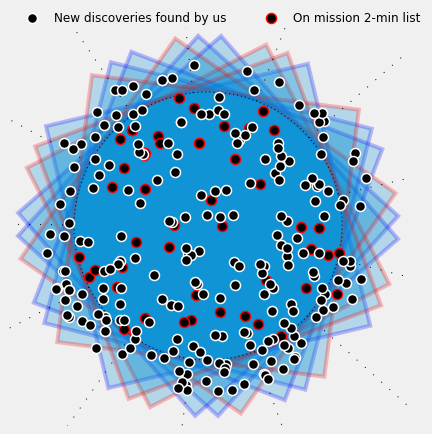

In [660]:

from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Wedge, Rectangle
with plt.style.context('fivethirtyeight'):
    fig, ax1 = plt.subplots(1,1, figsize=[6,6])
    m = Basemap(projection='aeqd',lon_0=0,lat_0=-90,resolution='l', ax=ax1, celestial=True,
               width=40E5, height=40E5)
#     m.scatter(newDF.ECLONG.values, newDF.ECLAT.values, 
#               s=0.1, alpha=0.1, latlon=True, marker='^',
#              color='m')

    m.scatter(qhigh.ECLONG.values, qhigh.ECLAT.values, 
              s=100.0, alpha=1.0, latlon=True, marker='o',
             color='k', edgecolor='white', linewidths=1.5, zorder=20, label='New discoveries found by us')
    m.scatter(q1high.ECLONG.values, q1high.ECLAT.values, 
              s=100.0, alpha=1.0, latlon=True, marker='o',
             color='k', edgecolor='red', linewidths=1.5, zorder=19, label='On mission 2-min list')
    
    parallels = [-78., -54, -30, -6, 6, 30, 54, 78, ]
    m.drawparallels(parallels, latmax=78, dashes=[1,3])
    meridians = np.linspace(240-12,360+240-12,14)[:-1]
    m.drawmeridians(meridians, dashes=[1,10], latmax=78)

    s = 0.67
    ts = ax1.transAxes
    coords = [0.5, 0.5]
    for a in np.linspace(240-12,360+240-12,14)[:-1][0:5]:
        tr = matplotlib.transforms.Affine2D().rotate_deg_around(coords[0],coords[1], a)
        t = tr + ts
        rect1 = Rectangle((.5-(s/2), 0.5-(s/2)), s, s, angle=0,
                       transform=t, alpha=0.25, zorder=0, edgecolor='blue', lw=4)
        ax1.add_patch(rect1)
    
    for a in np.linspace(240-12,360+240-12,14)[:-1][-4:]:
        tr = matplotlib.transforms.Affine2D().rotate_deg_around(coords[0],coords[1], a)
        t = tr + ts
        rect1 = Rectangle((.5-(s/2), 0.5-(s/2)), s, s, angle=0,
                       transform=t, alpha=0.25, zorder=0, edgecolor='red', lw=4)
        ax1.add_patch(rect1)


    plt.legend(bbox_to_anchor=(0.02, 0.99, 1.02, .102), loc=8,
           ncol=2, mode="expand", borderaxespad=0., fontsize=12, framealpha=0.0)
#     ax1.set_title('Southern Ecliptic Hemisphere', fontsize=15)
    fig.tight_layout()
    fig.savefig('skyplot_sectors.png', dpi=200)

AttributeError: module 'matplotlib.pyplot' has no attribute 'rotate_deg_around'

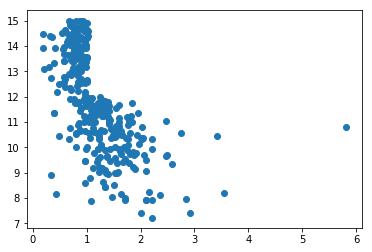

In [247]:
x = newDF.loc[newDF.detected_4months == True].RADIUS
y = newDF.loc[newDF.detected_4months == True].TESSMAG
plt.scatter(x,y)

(array([ 12.,  30.,   0.,   2.,   0.,   0.,   0.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14]),
 <a list of 7 Patch objects>)

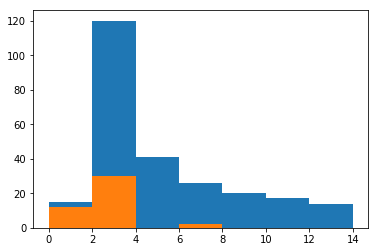

In [396]:
plt.hist(q.planetRadius, bins=np.arange(0,15,2))
plt.hist(q1.planetRadius, bins=np.arange(0,15,2))

(array([ 110.,   87.,   42.,   22.,   19.,    9.,    6.,    5.,    4.]),
 array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45]),
 <a list of 9 Patch objects>)

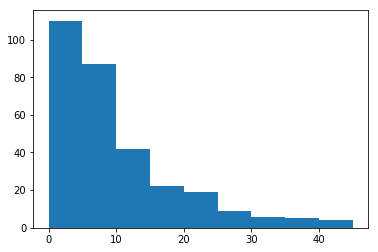

In [356]:
plt.hist(q.planetPeriod, np.arange(0,50,5))

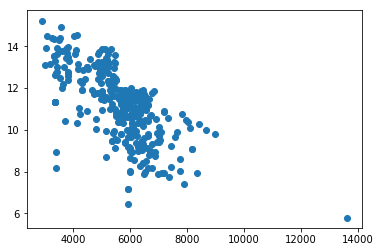

In [385]:
plt.scatter(newDF.TEFF[newDF.detected & (newDF.planetRadius < 4)], 
            newDF.TESSMAG[newDF.detected & (newDF.planetRadius < 4)])

In [402]:
np.percentile(q.planetRadius, 10)

2.8779894902586003

In [415]:
qhigh.planetRadius[q.planetRadius > 4].shape

(127,)

(array([ 11.,  19.,   9.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   2.,
          0.,   0.,   0.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140]),
 <a list of 14 Patch objects>)

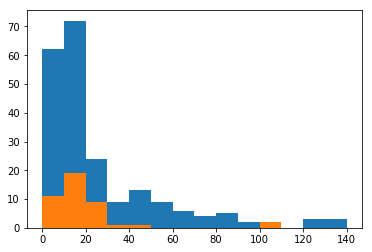

In [441]:
plt.hist(qhigh.needed_for_detection_4months / qhigh.noise_level* 7.3, bins=np.arange(0,150,10) )
plt.hist(q1high.needed_for_detection_4months / q1high.noise_level* 7.3, bins=np.arange(0,150,10) )

In [443]:
np.percentile(qhigh.needed_for_detection_4months / qhigh.noise_level * 7.3, 50)

14.880261333849649

(array([  2.,  10.,   9.,  21.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 15 Patch objects>)

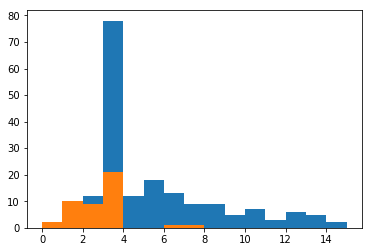

In [445]:
plt.hist(qhigh.planetRadius, bins=np.arange(0,16,1) )
plt.hist(q1high.planetRadius, bins=np.arange(0,16,1) )

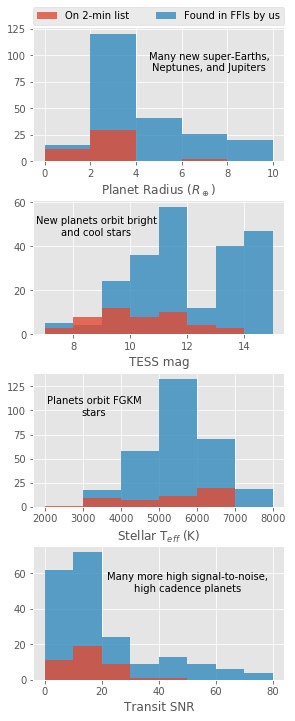

In [657]:

with plt.style.context('ggplot'):
    fig, [ax1,ax5, ax3,ax4] = plt.subplots(4,1, figsize=[4.5,12])
    
    h1 = ax1.hist(q1.planetRadius, bins=np.arange(0,12,2), alpha=0.8, zorder=20, 
             label='On 2-min list')
    h2 = ax1.hist(q.planetRadius, bins=np.arange(0,12,2), alpha=0.8, zorder=19, label='Found in FFIs by us')
    
    ax1.set_xlabel('Planet Radius ($R_\oplus$)')
    
#     ax2.hist(q.planetPeriod, bins=np.arange(0,50,5), alpha=0.8)
#     ax2.hist(q1.planetPeriod, bins=np.arange(0,50,5), alpha=0.8)
#     ax2.set_xlabel('Planet Period (d)')

    ax3.hist(q1.TEFF, bins=np.arange(2000, 9000, 1000), alpha=0.8, zorder=20)
    ax3.hist(q.TEFF, bins=np.arange(2000, 9000, 1000), alpha=0.8, zorder=19)

    ax3.set_xlabel('Stellar T$_{eff}$ (K)')
#     for tick in ax3.get_xticklabels():
#         tick.set_rotation(45)
    
#     ax4.scatter(q.planetPeriod, q.planetRadius)
#     ax4.scatter(q1.planetPeriod, q1.planetRadius)
    ax4.hist(q1high.needed_for_detection_4months / q1high.noise_level * 7.3, 
             bins=np.arange(0,90,10), alpha=0.8, zorder=20)
    ax4.hist(qhigh.needed_for_detection_4months / qhigh.noise_level * 7.3, 
             bins=np.arange(0,90,10), alpha=0.8, zorder=19)

    ax4.set_xlabel('Transit SNR')

    ax5.hist(q1high.TESSMAG, bins=np.arange(7,16,1), alpha=0.8, zorder=20)
    ax5.hist(qhigh.TESSMAG, bins=np.arange(7,16,1), alpha=0.8, zorder=19)

    ax5.set_xlabel('TESS mag')
    
    ax1.text(7.2,85,'Many new super-Earths,\nNeptunes, and Jupiters', horizontalalignment='center')
    ax5.text(8.8,45,'New planets orbit bright\nand cool stars', horizontalalignment='center')
    ax3.text(3300,95,'Planets orbit FGKM\nstars',horizontalalignment='center' )
    
    ax4.text(50,50,'Many more high signal-to-noise,\nhigh cadence planets', horizontalalignment='center' )

    
    ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    fig.subplots_adjust(hspace=0.29)
    fig.savefig('planet-properties.png')

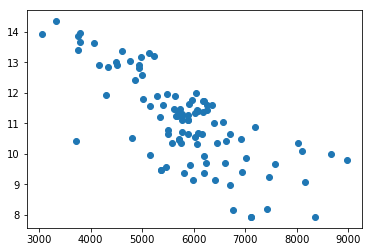

In [529]:
plt.scatter(qhigh.TEFF[qhigh.planetRadius < 4], qhigh.TESSMAG[qhigh.planetRadius < 4])

In [530]:
fnx = '../data/cvz-south-plus.csv.bz2'

newDFx = pd.read_csv(fnx)

In [523]:
newDFx.shape

(220201, 16)

In [524]:
fnx = '../data/cvz-south.csv.bz2'

newDFx = pd.read_csv(fnx)

In [525]:
newDFx.shape

(109504, 16)

(array([  1.42705000e+05,   1.68670000e+04,   1.45700000e+03,
          2.59000000e+02,   4.20000000e+01,   3.30000000e+01,
          1.50000000e+01,   7.00000000e+00,   2.00000000e+00,
          3.47000000e+02]),
 array([  1.89511980e-04,   1.00170561e-01,   2.00151610e-01,
          3.00132658e-01,   4.00113707e-01,   5.00094756e-01,
          6.00075805e-01,   7.00056854e-01,   8.00037902e-01,
          9.00018951e-01,   1.00000000e+00]),
 <a list of 10 Patch objects>)

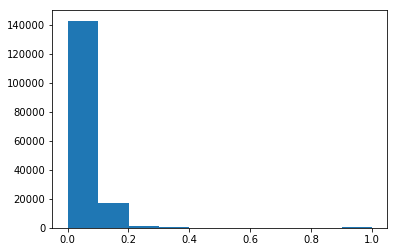

In [536]:
# plt.hist(newDF.TEFF)
plt.hist(newDF.PRIORITY)

(array([  148.,  3247.,   664.,  1180.,   623.]),
 array([2000, 3000, 4000, 5000, 6000, 7000]),
 <a list of 5 Patch objects>)

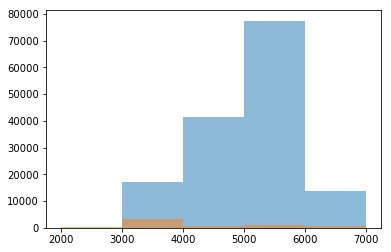

In [561]:

plt.hist(newDF.sort_values('PRIORITY').iloc[:-6000].loc[:,'TEFF'], 
         bins=np.arange(2000,8000,1000), alpha=0.5)
plt.hist(newDF.sort_values('PRIORITY').iloc[-6000:].loc[:,'TEFF'], bins=np.arange(2000,8000,1000), 
         alpha=0.5)

(array([  1.,   9.,   7.,  11.,  20.]),
 array([2000, 3000, 4000, 5000, 6000, 7000]),
 <a list of 5 Patch objects>)

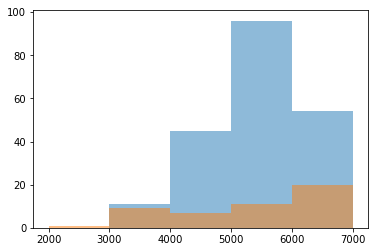

In [562]:
plt.hist(qhigh.loc[:,'TEFF'], 
         bins=np.arange(2000,8000,1000), alpha=0.5)
plt.hist(q1high.loc[:,'TEFF'], bins=np.arange(2000,8000,1000), 
         alpha=0.5)